<a href="https://colab.research.google.com/github/RKDash7/An-accurate-and-explainable-approach-towards-cardiac-disease-detection-using-Bi-LSTM/blob/main/Heart_BiLSTM_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **`Patient-wise splitting of PTB-XL dataset`**

In [ ]:
pip install wfdb torchsummary torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 49.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.2 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.


Import necessary packages

In [ ]:
import os
import ast
import wfdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow.keras as keras

sns.set_style('darkgrid')

In [ ]:
from zipfile import ZipFile

# specifying the zip file name
file_name = "/content/drive/MyDrive/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3.zip"

# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()

    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

Streaming output truncated to the last 5000 lines.
ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/records500/19000/19339_hr.hea 2020-04-23 10:17:02          609
ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/records500/19000/19340_hr.dat 2020-04-23 10:17:02       120000
ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/records500/19000/19340_hr.hea 2020-04-23 10:17:02          608
ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/records500/19000/19341_hr.dat 2020-04-23 10:17:02       120000
ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/records500/19000/19341_hr.hea 2020-04-23 10:17:02          600
ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/records500/19000/19342_hr.dat 2020-04-23 10:17:02       120000
ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/records500/19000/19342_hr.hea 2020-04-23 10:17:02          611
ptb-xl-a-large-publicly-availabl

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ============================
# Bi-directional LSTM for PTB-XL (5 superclasses)
# ============================

import os
import wfdb
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from scipy.signal import butter, filtfilt, iirnotch
from sklearn.model_selection import train_test_split

# --------------------------------------------------------
# 1. Filtering & Preprocessing
# --------------------------------------------------------
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(signal, lowcut=0.5, highcut=40, fs=100, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    return filtfilt(b, a, signal)

def notch_filter(signal, notch_freq=50, fs=100, Q=30):
    b, a = iirnotch(notch_freq, Q, fs)
    return filtfilt(b, a, signal)

def zscore_normalize(signal):
    mean = np.mean(signal)
    std = np.std(signal)
    return (signal - mean) / (std + 1e-8)

def preprocess_ecg(ecg_data, fs=100, target_len=1000, apply_notch=False):
    processed = []
    for lead in range(ecg_data.shape[0]):
        sig = ecg_data[lead]
        sig = bandpass_filter(sig, 0.5, 40, fs=fs)
        if apply_notch:
            sig = notch_filter(sig, notch_freq=50, fs=fs)
        sig = zscore_normalize(sig)
        if len(sig) > target_len:
            sig = sig[:target_len]
        elif len(sig) < target_len:
            sig = np.pad(sig, (0, target_len - len(sig)), 'constant')
        processed.append(sig)
    return np.array(processed)

# --------------------------------------------------------
# 2. Label Mapping (5 Superclasses)
# --------------------------------------------------------
def load_scored_labels(base_path):
    return pd.read_csv(os.path.join(base_path, "/content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/scp_statements.csv"), index_col=0)

def map_superclass(scp_codes_str, statements, super_classes):
    # Convert string dict -> dict
    scp_codes = eval(scp_codes_str)
    mapped = []
    for code in scp_codes.keys():
        if code in statements.index:
            sup = statements.loc[code].diagnostic_class
            if sup in super_classes:
                mapped.append(sup)
    if len(mapped) == 0:
        return None
    return mapped[0]  # take first main superclass

# --------------------------------------------------------
# 3. Load PTB-XL with patient-wise split
# --------------------------------------------------------
def load_ptbxl_patientwise(base_path, sampling_rate=100, target_len=1000, apply_notch=False):
    df = pd.read_csv(os.path.join(base_path, "/content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptbxl_database.csv"))
    statements = load_scored_labels(base_path)
    super_classes = ['NORM', 'MI', 'STTC', 'HYP', 'CD']

    # Choose correct filenames
    if sampling_rate == 100:
        df['filename'] = df['filename_lr'].apply(lambda x: os.path.join(base_path, x))
    else:
        df['filename'] = df['filename_hr'].apply(lambda x: os.path.join(base_path, x))

    # Map to superclasses
    df['superclass'] = df['scp_codes'].apply(lambda x: map_superclass(x, statements, super_classes))
    df = df[df['superclass'].notnull()]
    print(df['superclass'].value_counts())
    # Map to integers
    label_map = {sc: i for i, sc in enumerate(super_classes)}
    df['label'] = df['superclass'].map(label_map)

    # Patient-wise split
    patients = df['patient_id'].unique()
    train_pat, test_pat = train_test_split(patients, test_size=0.30, random_state=42)
    val_pat, test_pat = train_test_split(test_pat, test_size=0.50, random_state=42)

    split_map = {}
    for p in train_pat: split_map[p] = "train"
    for p in val_pat: split_map[p] = "val"
    for p in test_pat: split_map[p] = "test"

    df['split'] = df['patient_id'].map(split_map)

    datasets = {"train": [], "val": [], "test": []}
    labels = {"train": [], "val": [], "test": []}

    for idx, row in df.iterrows():
        record = wfdb.rdsamp(row['filename'])
        ecg_data = record[0].T
        processed = preprocess_ecg(ecg_data, fs=sampling_rate, target_len=target_len, apply_notch=apply_notch)
        datasets[row['split']].append(processed)
        labels[row['split']].append(row['label'])

    return datasets, labels, df, label_map

# --------------------------------------------------------
# 4. Torch Dataset Wrapper
# --------------------------------------------------------
class ECGDataset(Dataset):
    def __init__(self, signals, labels):
        self.signals = torch.tensor(np.array(signals), dtype=torch.float32)
        self.labels = torch.tensor(np.array(labels), dtype=torch.long)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.signals[idx], self.labels[idx]

# --------------------------------------------------------
# 5. Bi-LSTM Model
# --------------------------------------------------------
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_size=12, hidden_size=128, num_layers=2, num_classes=5, dropout=0.5):
        super(BiLSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        # x: (batch, channels, seq_len) -> (batch, seq_len, channels)
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last timestep
        out = self.fc(out)
        return out

# --------------------------------------------------------
# 6. Training Loop
# --------------------------------------------------------
def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, device="cuda"):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.to(device)
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        for signals, labels in train_loader:
            signals, labels = signals.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(signals)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_acc = correct / total
        train_accuracies.append(train_acc)
        # Validation
        model.eval()
        val_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for signals, labels in val_loader:
                signals, labels = signals.to(device), labels.to(device)
                outputs = model(signals)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Acc: {train_acc:.4f}, "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, "
              f"Val Acc: {val_acc:.4f}")

    return train_acc, val_acc,train_losses, val_losses



In [ ]:
# --------------------------------------------------------
# 7. Run Training
# --------------------------------------------------------
base_path = "/content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/"  # <-- update this
datasets, labels, df, label_map = load_ptbxl_patientwise(base_path, sampling_rate=100)

train_dataset = ECGDataset(datasets["train"], labels["train"])
val_dataset   = ECGDataset(datasets["val"], labels["val"])
test_dataset  = ECGDataset(datasets["test"], labels["test"])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

#model = BiLSTMClassifier(num_classes=len(label_map))
#train_accuracies, val_accuracies, train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=20, lr=1e-3, device="cuda" if torch.cuda.is_available() else "cpu")


superclass
NORM    9514
MI      5424
STTC    2817
CD      2325
HYP     1308
Name: count, dtype: int64


In [ ]:
print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))
print("Number of testing samples:", len(test_dataset))

Number of training samples: 14991
Number of validation samples: 3220
Number of testing samples: 3177


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import accuracy_score
import numpy as np


# ===================== BiLSTM Model =====================
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_size=12, hidden_size=128, num_layers=2, num_classes=5, dropout=0.5):
        super(BiLSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x, return_probs=False):
        # x: (batch, channels, seq_len) -> (batch, seq_len, channels)
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])  # last timestep
        logits = self.fc(out)

        if return_probs:
            return logits, F.softmax(logits, dim=1)
        return logits


# ===================== Early Stopping =====================
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.best_state = None

    def __call__(self, val_score, model):
        if self.best_score is None:
            self.best_score = val_score
            self.best_state = model.state_dict()
        elif val_score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_score
            self.best_state = model.state_dict()
            self.counter = 0

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=50, lr=1e-3, patience=5, device="cuda"):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    early_stopping = EarlyStopping(patience=patience)  # will track best val accuracy
    model.to(device)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # ---- Training ----
        model.train()
        train_loss = 0
        correct, total = 0, 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            logits = model(X)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X.size(0)
            _, predicted = torch.max(logits, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()


        avg_train_loss = train_loss/len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        train_acc = correct / total
        train_accuracies.append(train_acc)

        # ---- Validation ----
        model.eval()
        val_loss = 0
        y_true, y_pred, y_probs = [], [], []

        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                logits, probs = model(X, return_probs=True)
                loss = criterion(logits, y)

                val_loss += loss.item() * X.size(0)
                y_true.extend(y.cpu().numpy())
                y_pred.extend(torch.argmax(probs, 1).cpu().numpy())
                y_probs.extend(probs.cpu().numpy())

        # Metrics
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        acc = accuracy_score(y_true, y_pred)

        avg_val_loss = val_loss/len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        val_accuracies.append(acc)


        print(f"Epoch {epoch+1}/{num_epochs} "
              f"- Train Loss: {avg_train_loss:.4f} "
              f"- Val Loss: {avg_val_loss:.4f} "
              f"- Val Acc: {acc:.4f}")

        # ---- Early Stopping on Val Accuracy ----
        early_stopping(acc, model)
        if early_stopping.early_stop:
            print("Early stopping triggered (on validation accuracy)!")
            break

    # Load best model
    model.load_state_dict(early_stopping.best_state)
    return model, train_accuracies, val_accuracies, train_losses, val_losses

In [ ]:
from torchinfo import summary
import torch

def print_model_summary(model, seq_len, input_size=12, batch_size=1):
    """
    Prints a clean summary of a PyTorch model (BiLSTM/CNN/CNN+BiLSTM) for ECG input.

    Parameters:
    - model: PyTorch nn.Module
    - seq_len: sequence length (number of timesteps)
    - input_size: number of features per timestep (e.g., ECG leads)
    - batch_size: dummy batch size for summary
    """
    # Create a dummy input tensor
    dummy_input = torch.randn(batch_size, seq_len, input_size).float()

    # Pass dummy input via input_data to torchinfo
    print("===== Model Summary =====")
    summary(model, input_data=dummy_input, col_names=("input_size", "output_size", "num_params", "trainable"))

    # Print total and trainable parameters manually
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print("=========================")
model = BiLSTMClassifier(num_classes=len(label_map))
print_model_summary(model, seq_len=1000, input_size=12, batch_size=1)

===== Model Summary =====


RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

In [ ]:
model = BiLSTMClassifier(num_classes=len(label_map))
model, train_accuracies, val_accuracies, train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=8, lr=1e-2, device="cuda" if torch.cuda.is_available() else "cpu")

Epoch 1/8 - Train Loss: 1.3995 - Val Loss: 1.3925 - Val Acc: 0.4422
Epoch 2/8 - Train Loss: 1.3970 - Val Loss: 1.3903 - Val Acc: 0.4360
Epoch 3/8 - Train Loss: 1.3825 - Val Loss: 1.3783 - Val Acc: 0.4360
Epoch 4/8 - Train Loss: 1.3721 - Val Loss: 1.3676 - Val Acc: 0.4491
Epoch 5/8 - Train Loss: 1.3660 - Val Loss: 1.3528 - Val Acc: 0.4516
Epoch 6/8 - Train Loss: 1.3624 - Val Loss: 1.3454 - Val Acc: 0.4500
Epoch 7/8 - Train Loss: 1.3512 - Val Loss: 1.3414 - Val Acc: 0.4575
Epoch 8/8 - Train Loss: 1.3468 - Val Loss: 1.3319 - Val Acc: 0.4528


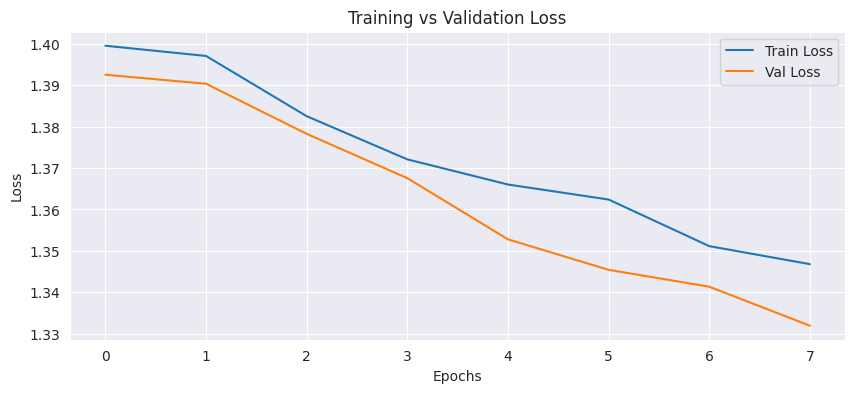

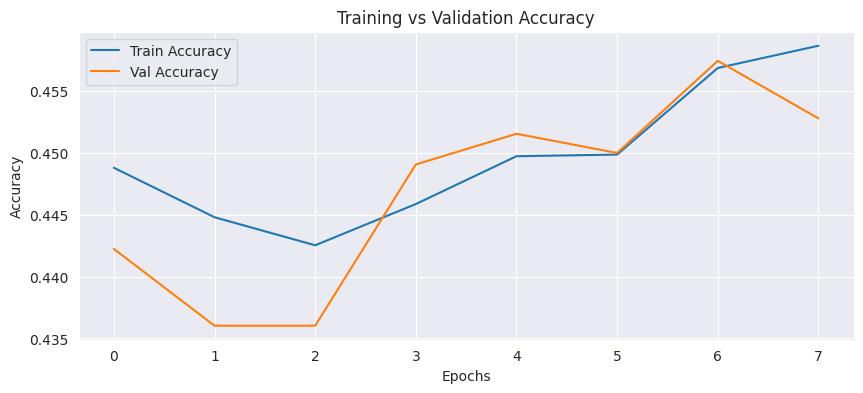

In [ ]:
# Loss curve
plt.figure(figsize=(10,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

# Accuracy curve
plt.figure(figsize=(10,4))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()


              precision    recall  f1-score   support

        NORM       0.46      0.99      0.63      1414
          MI       0.56      0.09      0.16       803
        STTC       0.00      0.00      0.00       406
          CD       0.00      0.00      0.00       226
         HYP       0.00      0.00      0.00       328

    accuracy                           0.47      3177
   macro avg       0.20      0.22      0.16      3177
weighted avg       0.35      0.47      0.32      3177



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


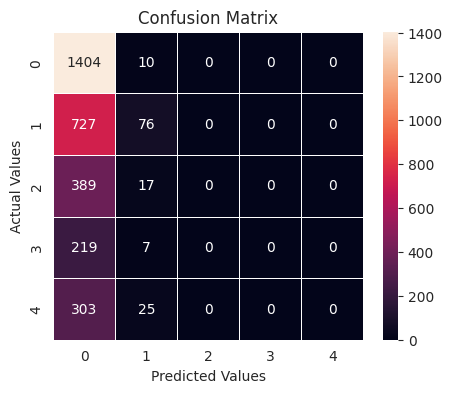

In [ ]:
# After training and testing
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
top_classes = df['superclass'].value_counts().index[:5]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for signals, labels in test_loader:
        signals, labels = signals.to(device), labels.to(device)
        outputs = model(signals)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=top_classes))
class_names = ["NORM", "MI", "STTC", "CD", "HYP"]
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True,linewidth=.5,fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# CNN Model
# ==============================
class ECG_CNN(nn.Module):
    def __init__(self, input_channels=12, num_classes=5):
        super(ECG_CNN, self).__init__()

        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(2)

        self.global_pool = nn.AdaptiveAvgPool1d(1)   # compress time dimension
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        # x shape: (batch, channels=12, timesteps)
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        x = self.global_pool(x).squeeze(-1)   # (batch, features)
        x = self.fc(x)
        return x

# ==============================
# Training Function
# ==============================
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20, device="cuda"):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    model.to(device)

    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        train_loss, correct, total = 0, 0, 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)

        train_acc = correct / total

        # ---- Validation ----
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = criterion(outputs, y)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y).sum().item()
                total += y.size(0)

        val_acc = correct / total

        # Save metrics
        history["train_loss"].append(train_loss/len(train_loader))
        history["val_loss"].append(val_loss/len(val_loader))
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {history['train_loss'][-1]:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {history['val_loss'][-1]:.4f}, Acc: {val_acc:.4f}")

    return model, history

# ==============================
# Plot Training Curves
# ==============================
def plot_history(history):
    plt.figure(figsize=(10,4))
    plt.plot(history['train_loss'], label="Train Loss")
    plt.plot(history['val_loss'], label="Val Loss")
    plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.title("Loss Curve")
    plt.legend(); plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(history['train_acc'], label="Train Accuracy")
    plt.plot(history['val_acc'], label="Val Accuracy")
    plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.title("Accuracy Curve")
    plt.legend(); plt.show()

# ==============================
# Evaluation
# ==============================
def evaluate_model(model, test_loader, device="cuda", class_names=None):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
    plt.show()


In [ ]:
from torchsummary import summary
num_classes = 5   # PTB-XL superclasses
class_names = ["NORM", "MI", "STTC", "CD", "HYP"]
model = ECG_CNN(input_channels=12, num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create model and move to device
model = ECG_CNN(input_channels=12, num_classes=5).to(device)

# Run summary on the same device
summary(model, (12, 1000), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 32, 1000]           2,720
       BatchNorm1d-2             [-1, 32, 1000]              64
         MaxPool1d-3              [-1, 32, 500]               0
            Conv1d-4              [-1, 64, 500]          10,304
       BatchNorm1d-5              [-1, 64, 500]             128
         MaxPool1d-6              [-1, 64, 250]               0
            Conv1d-7             [-1, 128, 250]          24,704
       BatchNorm1d-8             [-1, 128, 250]             256
         MaxPool1d-9             [-1, 128, 125]               0
AdaptiveAvgPool1d-10               [-1, 128, 1]               0
           Linear-11                    [-1, 5]             645
Total params: 38,821
Trainable params: 38,821
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/ba

Epoch 1/80 | Train Loss: 0.8705, Acc: 0.6874 | Val Loss: 0.7623, Acc: 0.7235
Epoch 2/80 | Train Loss: 0.7547, Acc: 0.7283 | Val Loss: 0.7335, Acc: 0.7347
Epoch 3/80 | Train Loss: 0.7293, Acc: 0.7380 | Val Loss: 0.8044, Acc: 0.7004
Epoch 4/80 | Train Loss: 0.7027, Acc: 0.7465 | Val Loss: 0.7012, Acc: 0.7469
Epoch 5/80 | Train Loss: 0.6883, Acc: 0.7524 | Val Loss: 0.7259, Acc: 0.7294
Epoch 6/80 | Train Loss: 0.6769, Acc: 0.7565 | Val Loss: 0.6738, Acc: 0.7528
Epoch 7/80 | Train Loss: 0.6613, Acc: 0.7601 | Val Loss: 0.6775, Acc: 0.7525
Epoch 8/80 | Train Loss: 0.6505, Acc: 0.7606 | Val Loss: 0.6787, Acc: 0.7444
Epoch 9/80 | Train Loss: 0.6407, Acc: 0.7677 | Val Loss: 0.6905, Acc: 0.7481
Epoch 10/80 | Train Loss: 0.6359, Acc: 0.7674 | Val Loss: 0.6679, Acc: 0.7590
Epoch 11/80 | Train Loss: 0.6290, Acc: 0.7710 | Val Loss: 0.6805, Acc: 0.7447
Epoch 12/80 | Train Loss: 0.6143, Acc: 0.7734 | Val Loss: 0.6768, Acc: 0.7597
Epoch 13/80 | Train Loss: 0.6066, Acc: 0.7798 | Val Loss: 0.7418, Acc: 0.

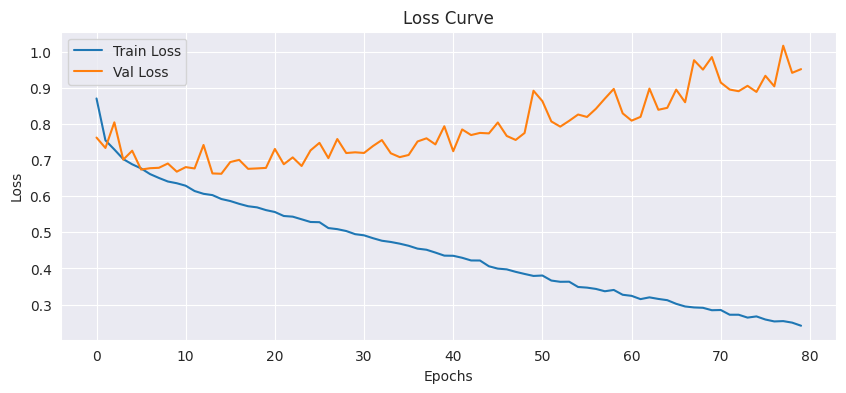

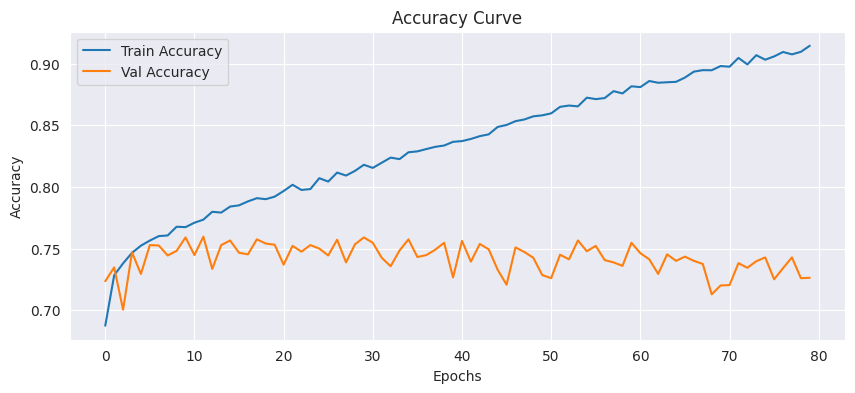


Classification Report:
              precision    recall  f1-score   support

        NORM       0.81      0.90      0.85      1434
          MI       0.77      0.66      0.71       838
        STTC       0.57      0.54      0.55       408
          CD       0.50      0.29      0.36       203
         HYP       0.56      0.67      0.61       350

    accuracy                           0.73      3233
   macro avg       0.64      0.61      0.62      3233
weighted avg       0.72      0.73      0.72      3233



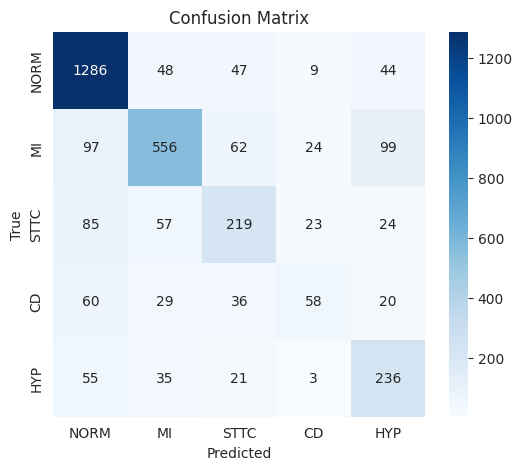

In [ ]:
num_classes = 5   # PTB-XL superclasses
class_names = ["NORM", "MI", "STTC", "CD", "HYP"]

model = ECG_CNN(input_channels=12, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=80)
plot_history(history)

# Evaluate
evaluate_model(model, test_loader, class_names=class_names)


Extracting features from CNN...
Training SVM...

Classification Report:
              precision    recall  f1-score   support

        NORM       0.78      0.91      0.84      1434
          MI       0.66      0.70      0.68       838
        STTC       0.52      0.51      0.52       408
          CD       0.61      0.07      0.12       203
         HYP       0.70      0.49      0.58       350

    accuracy                           0.71      3233
   macro avg       0.65      0.54      0.55      3233
weighted avg       0.70      0.71      0.68      3233



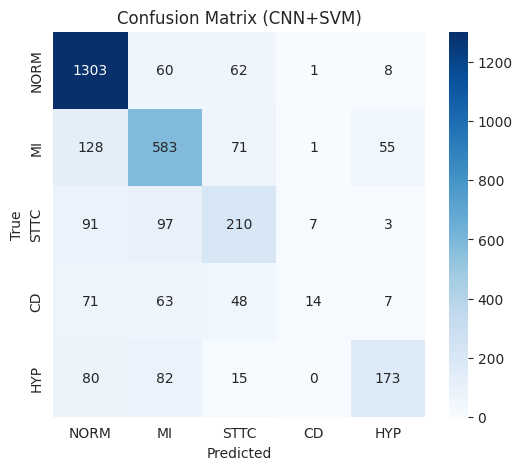

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ==============================
# CNN Feature Extractor
# ==============================
class ECG_CNN_FeatureExtractor(nn.Module):
    def __init__(self, input_channels=12, feature_dim=128):
        super(ECG_CNN_FeatureExtractor, self).__init__()

        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(2)

        self.global_pool = nn.AdaptiveAvgPool1d(1)   # compress time dimension

    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        x = self.global_pool(x).squeeze(-1)   # (batch, features=128)
        return x


# ==============================
# Extract Features using CNN
# ==============================
def extract_features(model, dataloader, device="cuda"):
    model.eval()
    features, labels = [], []

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            feat = model(X)
            features.append(feat.cpu().numpy())
            labels.append(y.numpy())

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels


# ==============================
# Train SVM on CNN Features
# ==============================
def train_cnn_svm(train_loader, test_loader, class_names, device="cuda"):
    cnn_model = ECG_CNN_FeatureExtractor().to(device)

    # ---- Extract train/test features ----
    print("Extracting features from CNN...")
    X_train, y_train = extract_features(cnn_model, train_loader, device)
    X_test, y_test = extract_features(cnn_model, test_loader, device)

    # ---- Train SVM ----
    print("Training SVM...")
    svm = SVC(kernel="rbf", C=10, gamma="scale")
    svm.fit(X_train, y_train)

    # ---- Evaluate ----
    y_pred = svm.predict(X_test)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix (CNN+SVM)")
    plt.show()


# ==============================
# Example Usage
# ==============================
# Assuming you already defined:
# train_loader, test_loader, class_names = [...]
device = "cuda" if torch.cuda.is_available() else "cpu"

train_cnn_svm(train_loader, test_loader, class_names, device)


Extracting features from CNN...
Training SVM...

Classification Report:
              precision    recall  f1-score   support

        NORM       0.78      0.92      0.84      1434
          MI       0.63      0.69      0.66       838
        STTC       0.53      0.48      0.50       408
          CD       0.64      0.07      0.12       203
         HYP       0.66      0.43      0.52       350

    accuracy                           0.70      3233
   macro avg       0.65      0.52      0.53      3233
weighted avg       0.69      0.70      0.67      3233



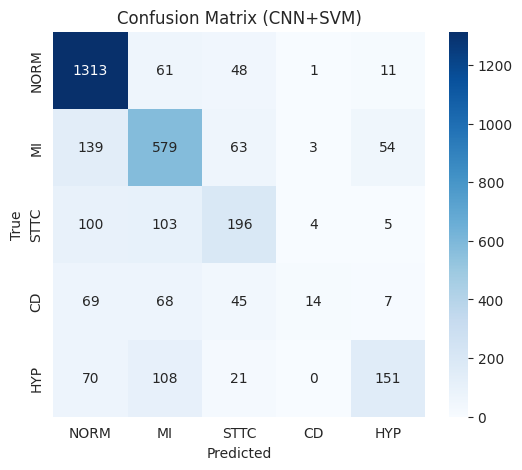

AttributeError: 'NoneType' object has no attribute 'children'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create model and move to device
model_DL = train_cnn_svm(train_loader, test_loader, class_names, device)

# Run summary on the same device
summary(model_DL, (32, 12, 1000), device=str(device))

Epoch 1/30 | Train Loss: 1.3307, Acc: 0.4744 | Val Loss: 1.2968, Acc: 0.5012
Epoch 2/30 | Train Loss: 1.1248, Acc: 0.5678 | Val Loss: 1.3159, Acc: 0.4907
Epoch 3/30 | Train Loss: 0.8660, Acc: 0.6793 | Val Loss: 1.4351, Acc: 0.4773
Epoch 4/30 | Train Loss: 0.5578, Acc: 0.7981 | Val Loss: 1.6993, Acc: 0.4677
Epoch 5/30 | Train Loss: 0.3279, Acc: 0.8873 | Val Loss: 1.9670, Acc: 0.4764
Epoch 6/30 | Train Loss: 0.2032, Acc: 0.9319 | Val Loss: 2.3449, Acc: 0.4764
Epoch 7/30 | Train Loss: 0.1692, Acc: 0.9419 | Val Loss: 2.4907, Acc: 0.4758
Epoch 8/30 | Train Loss: 0.1470, Acc: 0.9490 | Val Loss: 2.5797, Acc: 0.4702
Epoch 9/30 | Train Loss: 0.1198, Acc: 0.9574 | Val Loss: 2.8024, Acc: 0.4500
Epoch 10/30 | Train Loss: 0.1030, Acc: 0.9638 | Val Loss: 2.8582, Acc: 0.4674
Epoch 11/30 | Train Loss: 0.0910, Acc: 0.9680 | Val Loss: 2.9038, Acc: 0.4720
Epoch 12/30 | Train Loss: 0.1048, Acc: 0.9636 | Val Loss: 2.9893, Acc: 0.4596
Epoch 13/30 | Train Loss: 0.0852, Acc: 0.9706 | Val Loss: 3.0611, Acc: 0.

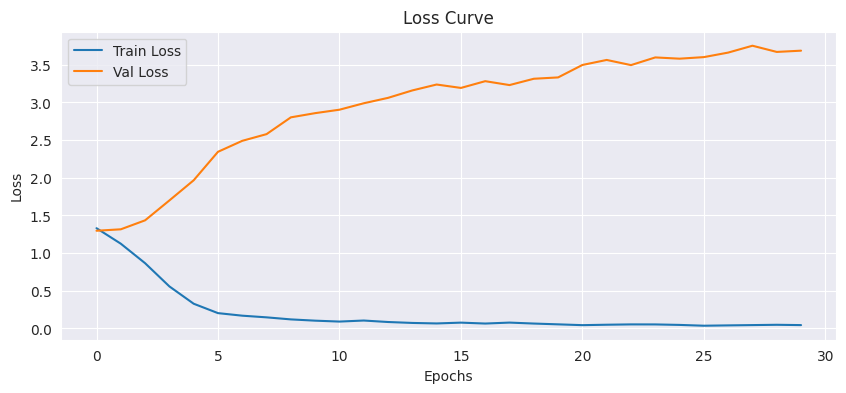

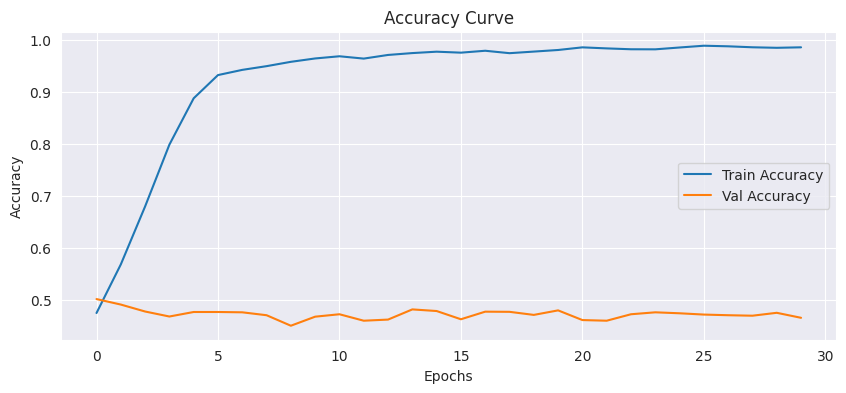


Classification Report:
              precision    recall  f1-score   support

        NORM       0.67      0.63      0.65      1414
          MI       0.40      0.54      0.46       803
        STTC       0.26      0.24      0.25       406
          CD       0.10      0.04      0.06       226
         HYP       0.21      0.20      0.20       328

    accuracy                           0.47      3177
   macro avg       0.33      0.33      0.32      3177
weighted avg       0.46      0.47      0.46      3177



NameError: name 'roc_auc_score' is not defined

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# ANN Model
# ==============================
import torch
import torch.nn as nn

class ECG_ANN(nn.Module):
    def __init__(self, input_size, num_classes=5):
        super(ECG_ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)   # was 1000 → should be 12000
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, num_classes)

    def forward(self, x):
        # x shape: (batch, 12, 1000)
        x = x.view(x.size(0), -1)  # → (batch, 12000)
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x



# ==============================
# Training Function
# ==============================
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20, device="cuda"):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)

        train_acc = correct / total

        # ---- Validation ----
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = criterion(outputs, y)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y).sum().item()
                total += y.size(0)

        val_acc = correct / total

        # Save metrics
        history["train_loss"].append(train_loss/len(train_loader))
        history["val_loss"].append(val_loss/len(val_loader))
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {history['train_loss'][-1]:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {history['val_loss'][-1]:.4f}, Acc: {val_acc:.4f}")

    return model, history

# ==============================
# Plot Curves
# ==============================
def plot_history(history):
    plt.figure(figsize=(10,4))
    plt.plot(history['train_loss'], label="Train Loss")
    plt.plot(history['val_loss'], label="Val Loss")
    plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.title("Loss Curve")
    plt.legend(); plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(history['train_acc'], label="Train Accuracy")
    plt.plot(history['val_acc'], label="Val Accuracy")
    plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.title("Accuracy Curve")
    plt.legend(); plt.show()

# ==============================
# Evaluation
# ==============================
def evaluate_model(model, test_loader, device="cuda", class_names=None):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    macro_auroc = roc_auc_score(y_true, y_pred, average="macro", multi_class="ovr")

# Step 3: Compute Macro AUPRC (one-vs-rest average precision)
    macro_auprc = average_precision_score(y_true, y_pred, average="macro")

    print(f"Macro AUROC: {macro_auroc:.4f}")
    print(f"Macro AUPRC: {macro_auprc:.4f}")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
    plt.show()

# ==============================
# Usage Example
# ==============================
device = "cuda" if torch.cuda.is_available() else "cpu"

# suppose your ECG features are already flattened into vectors (not sequences/images)
# Suppose X_train.shape = (N, 1000)  → 1000 features per sample
# The input signal shape is (batch, channels, time_steps), which is (batch, 12, 1000)
# Flattened size is 12 * 1000 = 12000
input_size = 12 * 1000
num_classes = 5          # adjust to your labels

model = ECG_ANN(input_size, num_classes).to(device)


model = ECG_ANN(input_size, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train model
model, history = train_model(model, train_loader, val_loader,
                             criterion, optimizer, epochs=30, device=device)

# Plot curves
plot_history(history)

# Evaluate
class_names = ['NORM','MI','STTC','CD','HYP']  # replace with your labels
evaluate_model(model, test_loader, device=device, class_names=class_names)

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score
evaluate_model(model, test_loader, device=device, class_names=class_names)


Classification Report:
              precision    recall  f1-score   support

        NORM       0.65      0.68      0.67      1414
          MI       0.41      0.55      0.47       803
        STTC       0.25      0.19      0.22       406
          CD       0.10      0.04      0.05       226
         HYP       0.21      0.15      0.17       328

    accuracy                           0.48      3177
   macro avg       0.32      0.32      0.32      3177
weighted avg       0.45      0.48      0.46      3177



AxisError: axis 1 is out of bounds for array of dimension 1


Classification Report:
              precision    recall  f1-score   support

        NORM       1.00      1.00      1.00      6627
          MI       1.00      1.00      1.00      3809
        STTC       1.00      0.99      1.00      1985
          CD       1.00      1.00      1.00       906
         HYP       1.00      1.00      1.00      1662

    accuracy                           1.00     14989
   macro avg       1.00      1.00      1.00     14989
weighted avg       1.00      1.00      1.00     14989



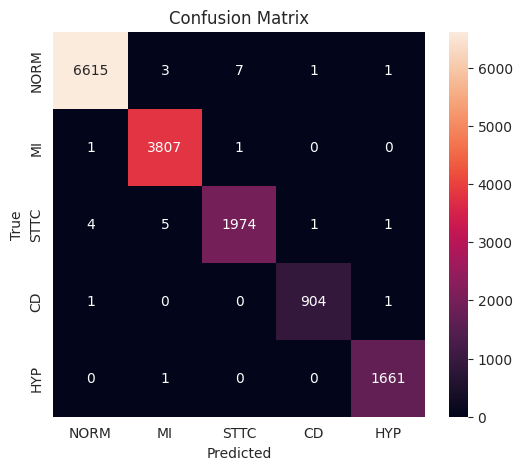

In [ ]:
def evaluate_model(model, test_loader, device="cuda", class_names=None):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
    plt.show()
class_names = ['NORM','MI','STTC','CD','HYP']
evaluate_model(model, train_loader, device=device, class_names=class_names)

In [ ]:
summary(model, input_size=( 12, 1000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]       6,144,512
       BatchNorm1d-2                  [-1, 512]           1,024
            Linear-3                  [-1, 256]         131,328
       BatchNorm1d-4                  [-1, 256]             512
            Linear-5                  [-1, 128]          32,896
       BatchNorm1d-6                  [-1, 128]             256
            Linear-7                    [-1, 5]             645
Total params: 6,311,173
Trainable params: 6,311,173
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.01
Params size (MB): 24.08
Estimated Total Size (MB): 24.13
----------------------------------------------------------------


In [ ]:
import torch
import torch.nn as nn

class ECG_ANN_FeatureExtractor(nn.Module):
    def __init__(self, input_size=12000, embed_dim=128):
        super(ECG_ANN_FeatureExtractor, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, embed_dim)  # embedding output
        self.bn3 = nn.BatchNorm1d(embed_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten → (batch, 12000)
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = torch.relu(self.bn3(self.fc3(x)))
        return x   # no softmax → we use as features


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ECG_ANN_FeatureExtractor().to(device)

# Assume model is trained (otherwise pre-train with CrossEntropy first)
model.eval()

X_train, y_train = [], []
X_test, y_test = [], []

with torch.no_grad():
    for data, labels in train_loader:
        data, labels = data.to(device), labels.cpu().numpy()
        feats = model(data).cpu().numpy()
        X_train.append(feats)
        y_train.append(labels)

    for data, labels in test_loader:
        data, labels = data.to(device), labels.cpu().numpy()
        feats = model(data).cpu().numpy()
        X_test.append(feats)
        y_test.append(labels)

X_train = np.vstack(X_train)
y_train = np.concatenate(y_train)
X_test = np.vstack(X_test)
y_test = np.concatenate(y_test)


In [ ]:
svm = SVC(kernel="rbf", C=10, gamma="scale")
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.47      0.70      0.56      1434
           1       0.29      0.26      0.28       838
           2       0.15      0.07      0.09       408
           3       0.00      0.00      0.00       203
           4       0.16      0.07      0.10       350

    accuracy                           0.40      3233
   macro avg       0.22      0.22      0.21      3233
weighted avg       0.32      0.40      0.34      3233



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf = RandomForestClassifier(
    n_estimators=200,  # number of trees
    max_depth=20,     # limit tree depth
    random_state=42,
    n_jobs=-1         # use all cores
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.44      1.00      0.61      1434
           1       0.40      0.00      0.00       838
           2       0.00      0.00      0.00       408
           3       0.00      0.00      0.00       203
           4       0.00      0.00      0.00       350

    accuracy                           0.44      3233
   macro avg       0.17      0.20      0.12      3233
weighted avg       0.30      0.44      0.27      3233



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import torch
import torch.nn as nn

class ECG_LSTM(nn.Module):
    def __init__(self, input_size=12, hidden_size=128, num_layers=2, num_classes=5, dropout=0.3):
        super(ECG_LSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_size * 2, num_classes) # * 2 for bidirectional

    def forward(self, x):
        # Handle extra dimension
        if x.dim() == 4 and x.shape[-1] == 1:
            x = x.squeeze(-1)         # (B, 12, 1000, 1) -> (B, 12, 1000)

        # Rearrange to (batch, seq_len, input_size)
        x = x.permute(0, 2, 1)        # (B, 12, 1000) -> (B, 1000, 12)

        out, _ = self.lstm(x)         # pass through LSTM
        out = out[:, -1, :]           # last timestep
        out = self.fc(out)
        return out

In [ ]:
from torchinfo import summary
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ECG_LSTM(input_size=12, hidden_size=128, num_layers=2, num_classes=5).to(device)

# Example input: 12-lead ECG with 1000 samples per lead
# We reshape it as (batch, seq_len=1000, input_size=12) if treating leads as features
# OR (batch, seq_len=1000, input_size=1) if processing one lead at a time
# The model expects input of shape (batch, channels, seq_len)
summary(model, input_size=(32, 12, 1000), device=str(device))

Layer (type:depth-idx)                   Output Shape              Param #
ECG_LSTM                                 [32, 5]                   --
├─LSTM: 1-1                              [32, 1000, 128]           204,800
├─Linear: 1-2                            [32, 5]                   645
Total params: 205,445
Trainable params: 205,445
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 6.55
Input size (MB): 1.54
Forward/backward pass size (MB): 32.77
Params size (MB): 0.82
Estimated Total Size (MB): 35.13

In [ ]:
import torch.optim as optim
from sklearn.metrics import classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ECG_LSTM(input_size=12, hidden_size=128, num_layers=2, num_classes=5).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 2
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    correct, total, epoch_loss = 0, 0, 0

    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)

        # Reshape: (batch, 12, 1000) -> The model's forward method handles permutation

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_losses.append(epoch_loss / len(train_loader))
    train_accs.append(correct / total)

    # ---- Validation ----
    model.eval()
    correct, total, val_loss = 0, 0, 0
    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            # No reshaping needed, model's forward handles permutation
            outputs = model(data)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(correct / total)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}")

Epoch [1/2] Train Loss: 1.3547, Train Acc: 0.4784, Val Loss: 1.2635, Val Acc: 0.5570
Epoch [2/2] Train Loss: 1.2709, Train Acc: 0.5440, Val Loss: 1.2828, Val Acc: 0.5330


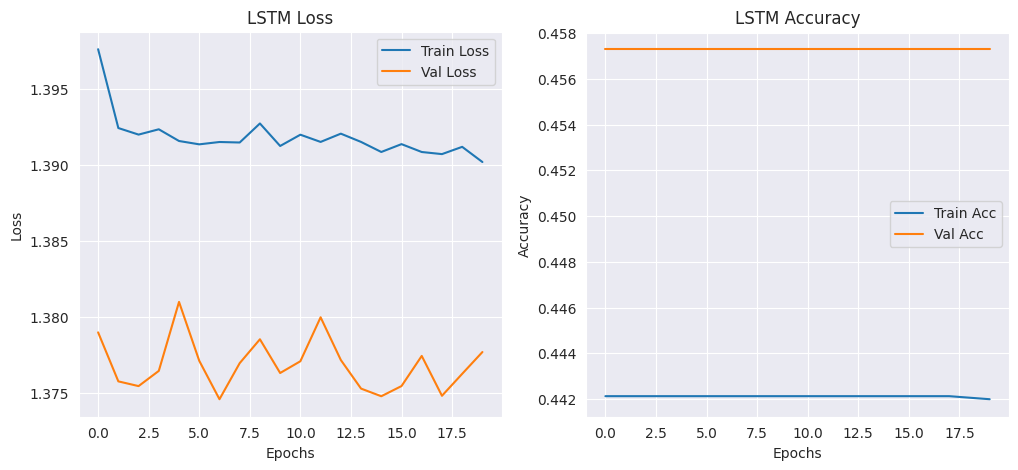

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.title("LSTM Loss")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.title("LSTM Accuracy")
plt.legend()

plt.show()


In [ ]:
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        data = data[:, 0, :].unsqueeze(-1)
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.44      0.99      0.61      1434
           1       0.21      0.01      0.02       838
           2       0.00      0.00      0.00       408
           3       0.00      0.00      0.00       203
           4       0.00      0.00      0.00       350

    accuracy                           0.44      3233
   macro avg       0.13      0.20      0.13      3233
weighted avg       0.25      0.44      0.28      3233



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# ==========================
# PTB-XL ECG Classification with Explainability (Grad-CAM)
# ==========================

#!pip install wfdb torch torchvision torchaudio scikit-learn matplotlib seaborn shap


import shap

# =====================
# Load PTB-XL Metadata
# =====================
'''
From google.colab import drive
drive.mount('/content/drive')

# Path to your PTB-XL zip file
zip_path = "/content/drive/MyDrive/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1.zip"

# Unzip it inside /content/
import zipfile
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/ptbxl")

print("✅ PTB-XL dataset extracted!")

'''
df

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,filename,superclass,label,split
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,/content/records100/00000/00001_lr,NORM,0,test
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,/content/records100/00000/00002_lr,NORM,0,train
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,/content/records100/00000/00003_lr,NORM,0,train
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,/content/records100/00000/00004_lr,NORM,0,val
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,/content/records100/00000/00005_lr,NORM,0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21832,21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,...,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr,/content/records100/21000/21833_lr,STTC,2,train
21833,21834,20703.0,93.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,...,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr,/content/records100/21000/21834_lr,NORM,0,val
21834,21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,...,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr,/content/records100/21000/21835_lr,STTC,2,train
21835,21836,8873.0,64.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-09 18:21:49,...,NaN,SVES,NaN,8,records100/21000/21836_lr,records500/21000/21836_hr,/content/records100/21000/21836_lr,NORM,0,val


Signal shape: (1000, 12)
Metadata: {'fs': 100, 'sig_len': 1000, 'n_sig': 12, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV'], 'sig_name': ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], 'comments': []}


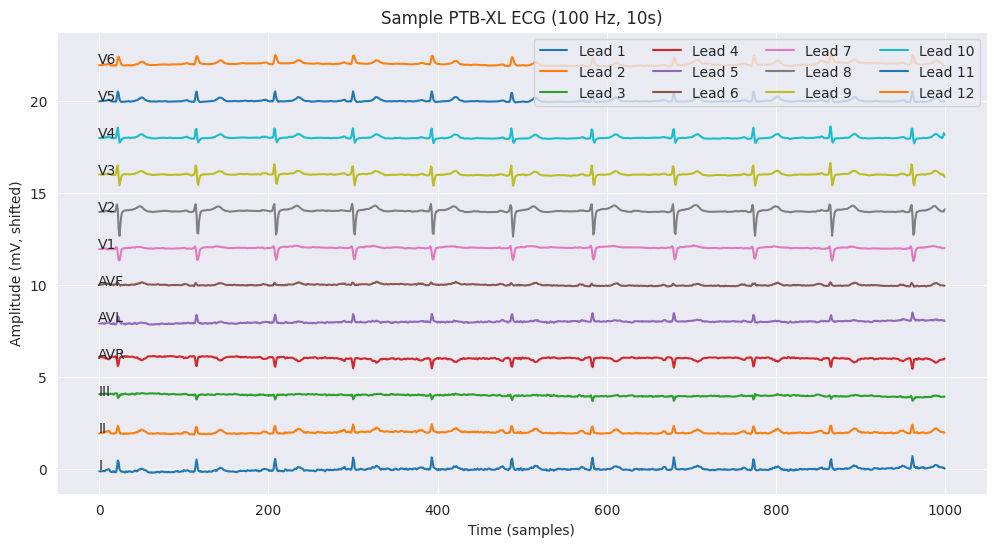

In [ ]:
import matplotlib.pyplot as plt
data_path = "/content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/"
sample_file = data_path + df.loc[0, 'filename_lr']  # low-resolution ECG (100 Hz)
record = wfdb.rdsamp(sample_file)

signal = record[0]   # numpy array, shape (1000, 12) -> 1000 samples, 12 leads
fields = record[1]   # metadata
print("Signal shape:", signal.shape)
print("Metadata:", fields)
plt.figure(figsize=(12, 6))
for i in range(12):
    plt.plot(signal[:, i] + i*2, label=f"Lead {i+1}")  # offset each lead
    plt.text(-1,2*i,fields['sig_name'][i])
plt.title("Sample PTB-XL ECG (100 Hz, 10s)")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (mV, shifted)")
plt.legend(loc="upper right", ncol=4)
plt.show()


In [ ]:
# ====== Install + Imports ======
#!pip install -q shap

import torch
import shap
import numpy as np
import matplotlib.pyplot as plt

# Disable cuDNN for RNNs as a workaround for SHAP compatibility
torch.backends.cudnn.enabled = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = ECG_LSTM(input_size=12, hidden_size=128, num_layers=2, num_classes=len(label_map)).to(device) # Keep model on device but don't set to eval yet

# ====== Build a small GPU background set (critical for speed/RAM) ======
# Take 8-16 training samples as background; more = heavier
with torch.no_grad():
    background = next(iter(train_loader))[0][:100].to(device)   # (16, 12, 1000)

# ====== Pick a small test batch to explain ======
with torch.no_grad():
    sample_data, sample_labels = next(iter(train_loader))
sample_data = sample_data[:100].to(device)                       # (8, 12, 1000)

# ====== SHAP GradientExplainer on GPU ======
# Works with differentiable PyTorch models; runs on GPU automatically.

# Set model to training mode for GradientExplainer to work
#model.train()
explainer = shap.GradientExplainer(model, background)

# Compute SHAP values for the batch (returns one array per class)
# Keep the batch small to avoid OOM.
shap_values = explainer.shap_values(sample_data)  # list length = num_classes

# Set model back to evaluation mode after computing SHAP values
model.eval()

# Each element has shape: (batch, 12, 1000)  <-- per-lead, per-timestep at input resolution

# ====== Pick target class per sample (predicted class) ======
with torch.no_grad():
    logits = model(sample_data)                     # (batch, num_classes)
pred = logits.argmax(dim=1)                         # (batch,)

In [ ]:
for i in range(50):
  print(i, int(pred[i].item()))

0 2
1 0
2 0
3 0
4 1
5 1
6 1
7 0
8 3
9 4
10 0
11 1
12 0
13 4
14 2
15 1
16 0
17 0
18 0
19 1
20 2
21 0
22 1
23 4
24 0
25 0
26 0
27 1
28 1
29 0
30 0
31 1


IndexError: index 32 is out of bounds for dimension 0 with size 32

Type of shap_values: <class 'numpy.ndarray'>
Shape of shap_values: (32, 12, 1000, 5)
Shape of sv: (12, 1000)


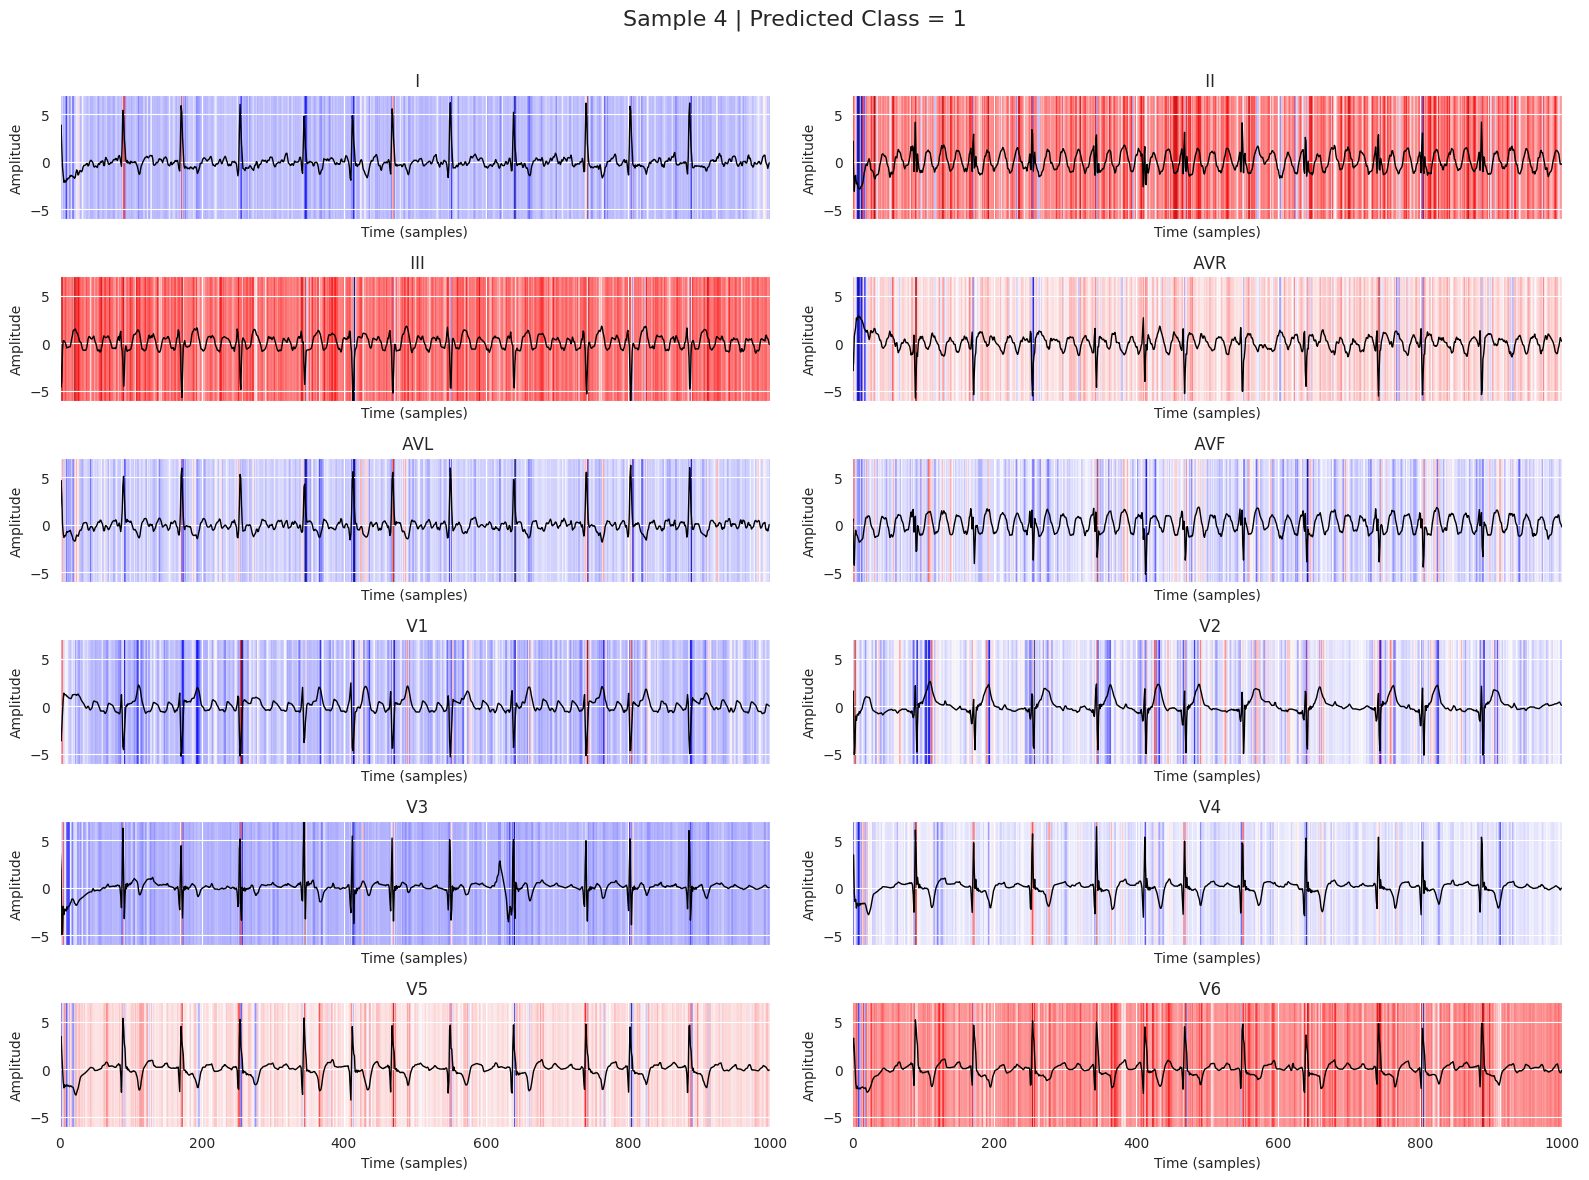

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Choose which sample index to plot from the batch (0 to batch_size - 1)
sample_index_to_plot = 4
if sample_index_to_plot >= sample_data.shape[0]:
    print(f"Sample index {sample_index_to_plot} is out of bounds for a batch of size {sample_data.shape[0]}.")
else:
    i = sample_index_to_plot
    target_class = int(pred[i].item())

    print(f"Type of shap_values: {type(shap_values)}")
    if isinstance(shap_values, list):
        print(f"Length of shap_values: {len(shap_values)}")
        for j, val in enumerate(shap_values):
            if hasattr(val, 'shape'):
                print(f"Shape of shap_values[{j}]: {val.shape}")
            else:
                print(f"Type of shap_values[{j}]: {type(val)}")
    elif hasattr(shap_values, 'shape'):
         print(f"Shape of shap_values: {shap_values.shape}")


    # Hypothesis: shap_values is a single numpy array with shape (batch_size, leads, time_steps, num_classes)
    # Indexing to get SHAP values for sample i and target_class:
    try:
        sv = shap_values[i, :, :, target_class]
        print(f"Shape of sv: {sv.shape}")
    except IndexError as e:
         print(f"IndexError during indexing with [i, :, :, target_class]: {e}")
         raise


    sig = sample_data[i].cpu().numpy()   # shape: (12,1000)

    fig, axes = plt.subplots(6, 2, figsize=(16, 12), sharex=True)
    axes = axes.flatten()

    for lead in range(12):
        ax = axes[lead]

        # Normalize SHAP values for coloring
        importance = sv[lead]
        # Handle cases where importance is all the same value (e.g., all zeros)
        if importance.max() - importance.min() > 1e-8:
             importance_norm = (importance - importance.min()) / (importance.max() - importance.min())
        else:
             importance_norm = np.zeros_like(importance) # Or handle as appropriate

        # Plot ECG waveform
        ax.plot(sig[lead], color="black", linewidth=1.0)

        # Overlay SHAP heatmap
        # Use extent to correctly map data coordinates to image coordinates
        ax.imshow(importance_norm[np.newaxis, :],
                  aspect="auto",
                  cmap="seismic",    # red = positive impact, blue = negative
                  extent=[0, sig.shape[1], sig.min(), sig.max()], # xmin, xmax, ymin, ymax
                  alpha=0.9)

        ax.set_title(f" {fields['sig_name'][lead]}")
        ax.set_ylabel("Amplitude")
        ax.set_xlabel("Time (samples)")


    plt.suptitle(f"Sample {i} | Predicted Class = {target_class}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig(f"sample_{i}_pred_{target_class}.png",dpi=100)
    plt.show()